# Import packages

In [1]:
import matplotlib.pyplot as plt
import glob 
import numpy as np
import os
import random
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
import tensorflow as tf
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2 
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_absolute_error as mae

## load data

In [2]:
df = pd.read_csv('../datasets/portfolio_data.csv')
print(df.head(10))

        Date        AMZN        DPZ         BTC       NFLX
0   5/1/2013  248.229996  51.190983  106.250000  30.415714
1   5/2/2013  252.550003  51.987320   98.099998  30.641428
2   5/3/2013  258.049988  52.446388  112.900002  30.492857
3   5/6/2013  255.720001  53.205257  109.599998  30.098572
4   5/7/2013  257.730011  54.151505  113.199997  29.464285
5   5/8/2013  258.679993  54.385727  112.800003  29.801428
6   5/9/2013  260.160004  54.020340  117.699997  30.915714
7  5/10/2013  263.630005  54.357620  115.639999  31.098572
8  5/13/2013  264.510010  54.573097  111.400002  32.768570
9  5/14/2013  268.329987  55.275757  114.220001  33.424286


In [115]:
df['Date'] = pd.to_datetime(df['Date'])

## clean data and only keep AMZN prices

In [116]:
clean_df = df.drop(columns=['DPZ', 'BTC', 'NFLX'])
print(clean_df.head(10))

        Date        AMZN
0 2013-05-01  248.229996
1 2013-05-02  252.550003
2 2013-05-03  258.049988
3 2013-05-06  255.720001
4 2013-05-07  257.730011
5 2013-05-08  258.679993
6 2013-05-09  260.160004
7 2013-05-10  263.630005
8 2013-05-13  264.510010
9 2013-05-14  268.329987


In [117]:
clean_df.sort_values(by='Date', inplace=True)
clean_df.head(-20)

,Date,AMZN
0,2013-05-01,248.229996
1,2013-05-02,252.550003
2,2013-05-03,258.049988
3,2013-05-06,255.720001
4,2013-05-07,257.730011
...,...,...
1495,2019-04-09,1835.839966
1496,2019-04-10,1847.329956
1497,2019-04-11,1844.069946
1498,2019-04-12,1843.060059


## Plot data

In [118]:
clean_df.set_index('Date', inplace=True)

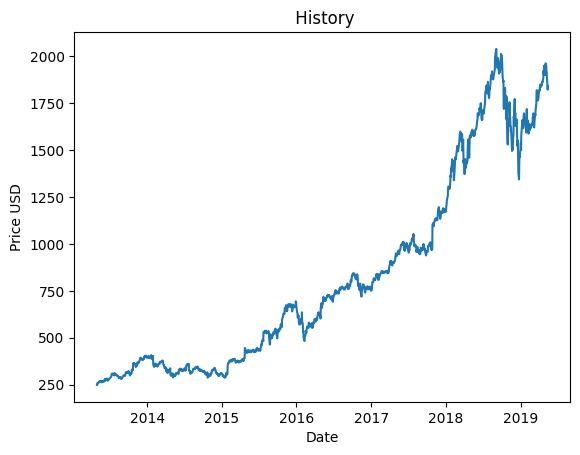

In [119]:
plt.title(' History')
plt.plot(clean_df["AMZN"])
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.show()

In [120]:
price_data = np.array(clean_df.iloc[:])
price_data

array([[ 248.229996],
       [ 252.550003],
       [ 258.049988],
       ...,
       [1889.97998 ],
       [1822.680054],
       [1840.119995]])

# Splitting data

In [121]:
ratio=0.80

train_size=int(len(price_data)*ratio)
test_size=len(price_data)-train_size

print(f"all data: {len(price_data)}\ntrain data: {train_size}\ntest data: {test_size}")

all data: 1520
train data: 1216
test data: 304


## Normalize data

In [122]:
scaler = MinMaxScaler(feature_range=(0,1))
normalized_data = scaler.fit_transform(price_data.reshape(-1,1)) # it is better to normalize data after train/test splitting to make sure you are not using any information from test data
normalized_data.shape

(1520, 1)

In [123]:
train_data,test_data=normalized_data[:train_size],normalized_data[train_size:]
train_data.shape, test_data.shape

((1216, 1), (304, 1))

## Dense Models

### *Input*=> 20 days   , *Output* => 1 day

In [250]:
def create_dataset(dataset,time_step_in=1,time_step_out=1):
    X, Y =[], []
    
    for i in range(len(dataset) - time_step_in):
        a = dataset[i:(i + time_step_in - time_step_out + 1),0]
        X.append(a)
        Y.append(dataset[i + time_step_in,0])
    return np.array(X), np.array(Y)

In [251]:
time_step=20
X_train,y_train=create_dataset(train_data,time_step_in=time_step,time_step_out=1)
X_test,y_test=create_dataset(test_data,time_step)
print(f"X_train: {X_train.shape} \ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (1196, 20) 
y_train: (1196,)
X_test: (284, 20)
y_test: (284,)


In [252]:
dense_model_1=Sequential()
dense_model_1.add(Dense(512,input_shape=(20,),activation="relu"))
dense_model_1.add(Dense(256,activation="relu"))
dense_model_1.add(Dense(128,activation="relu"))
dense_model_1.add(Dense(256,activation="relu"))
dense_model_1.add(Dense(128,activation="relu"))
dense_model_1.add(Dense(1))
dense_model_1.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.0001), metrics=['mean_absolute_error'])
dense_model_1.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                │ (None, 512)            │        10,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,025 (941.50 KB)

 Trainable params: 241,025 (941.50 KB)

 Non-trainable params: 0 (0.00 B)

In [253]:
history_1= dense_model_1.fit(
    X_train,y_train,
    epochs=100,              
    validation_data=(X_test,y_test),  
    verbose=1  
)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1023 - mean_absolute_error: 0.1023 - val_loss: 0.0350 - val_mean_absolute_error: 0.0350
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110 - mean_absolute_error: 0.0110 - val_loss: 0.0264 - val_mean_absolute_error: 0.0264
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0227 - val_mean_absolute_error: 0.0227
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - mean_absolute_error: 0.0071 - val_loss: 0.0256 - val_mean_absolute_error: 0.0256
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 - mean_absolute_error: 0.0057 - val_loss: 0.0188 - val_mean_absolute_error: 0.0188
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - mean_absolute_error: 0.0055 - val_loss

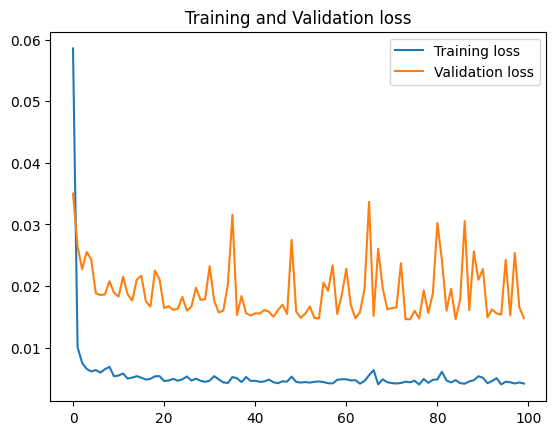

In [254]:
def history_plot(history):
    plt.plot(history.history['loss'],label='Training loss')
    plt.plot(history.history['val_loss'],label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()
history_plot(history_1)

In [255]:
train_predict = dense_model_1.predict(X_train)
test_predict = dense_model_1.predict(X_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [256]:
def mse(y_actual,y_pred):
    return  np.mean((np.array(y_actual) - np.array(y_pred)) ** 2)

# calculate MSE
mse_error=mse(y_train,train_predict)
print(f"Mean Squared error : {mse_error} " )

# calculate MAE
mae_error= mae(y_train,train_predict)
print(f"Mean absolute error : {mae_error} ")

Mean Squared error : 0.05290762967736506 
Mean absolute error : 0.003832602127925256 


## Function for Plot

### Comparison of Actual and  Predicted train and test Values

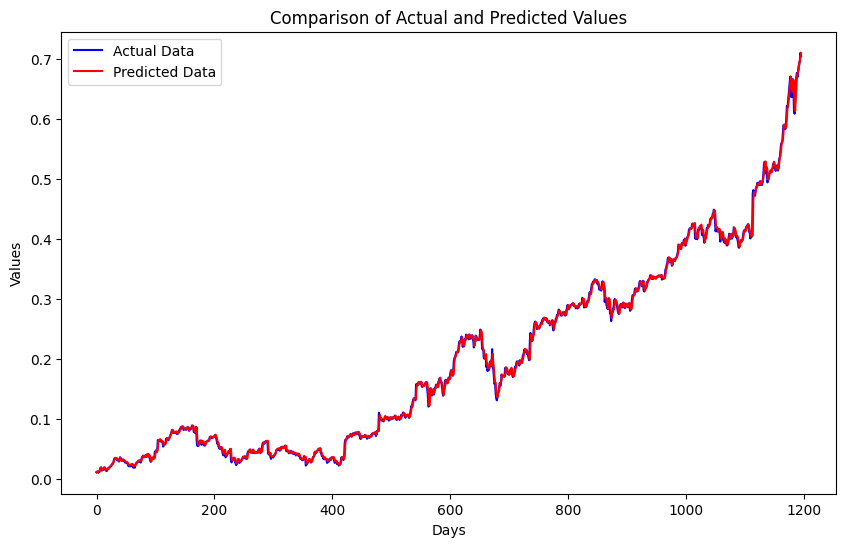

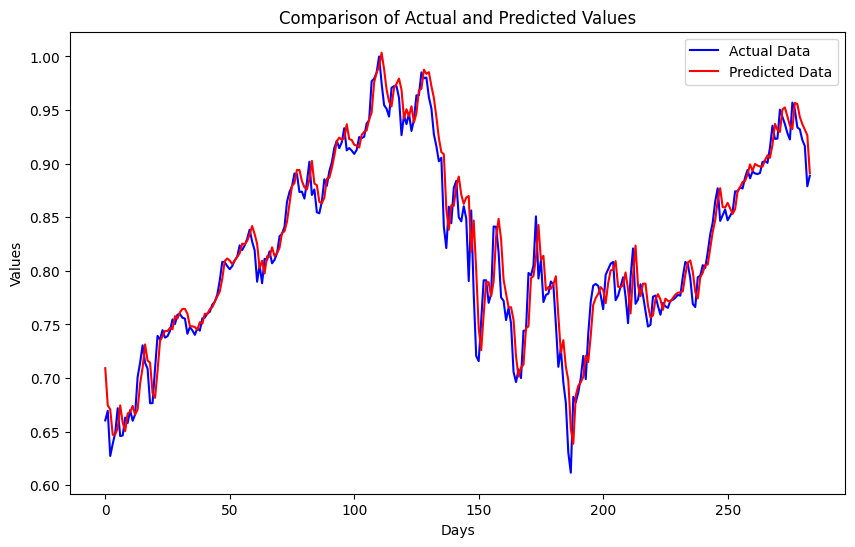

In [257]:
def model_plot(actual_data, predict_data):
    plt.figure(figsize=(10, 6))
    plt.plot(actual_data, label='Actual Data', color='blue')
    plt.plot(predict_data, label='Predicted Data', color='red')
    plt.title('Comparison of Actual and Predicted Values') 
    plt.xlabel('Days')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

model_plot(y_train, train_predict)
model_plot(y_test, test_predict)

### Use the model for price forcasting

In [258]:
x_train_first_20 = X_train[0]
x_train_first_20.shape

(20,)

In [260]:
def price_forecasting(model, n_step_forecast=1):
    y_prediction_day = []
    input_window= X_train[0]

    for i in range(1, n_step_forecast + 1):
        print(f'Step {i} ==> X_train: {input_window}')
        y_temp = model.predict(input_window.reshape(1, -1))
        y_prediction_day.append(y_temp[0]) 
        input_window = np.roll(input_window, -1, axis=0)
        input_window[-1] = y_temp 
    return np.array(y_prediction_day)

predictions = price_forecasting(dense_model_1, n_step_forecast=7)
print(predictions)

Step 1 ==> X_train: [0.         0.00241169 0.00548211 0.00418137 0.00530348 0.00583382
 0.00666005 0.00859721 0.00908848 0.01122102 0.01023291 0.00887075
 0.01209749 0.01083025 0.0115169  0.00822317 0.00757558 0.00754209
 0.01064044 0.0096579 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Step 2 ==> X_train: [0.00241169 0.00548211 0.00418137 0.00530348 0.00583382 0.00666005
 0.00859721 0.00908848 0.01122102 0.01023291 0.00887075 0.01209749
 0.01083025 0.0115169  0.00822317 0.00757558 0.00754209 0.01064044
 0.0096579  0.01098366]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Step 3 ==> X_train: [0.00548211 0.00418137 0.00530348 0.00583382 0.00666005 0.00859721
 0.00908848 0.01122102 0.01023291 0.00887075 0.01209749 0.01083025
 0.0115169  0.00822317 0.00757558 0.00754209 0.01064044 0.0096579
 0.01098366 0.0117082 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Step 4 ==> X_train: [0.00418137 0.00530348 0.00583382 0.00666005 0.00859721 0.00908848
 0.01122102 0.01023291 0.00887075 0.01209749 0.01083025 0.0115169

In [261]:
x_input = np.array(X_train[0])
y_output = np.array(predictions).reshape(-1)
x_input.shape, y_output.shape

((20,), (7,))

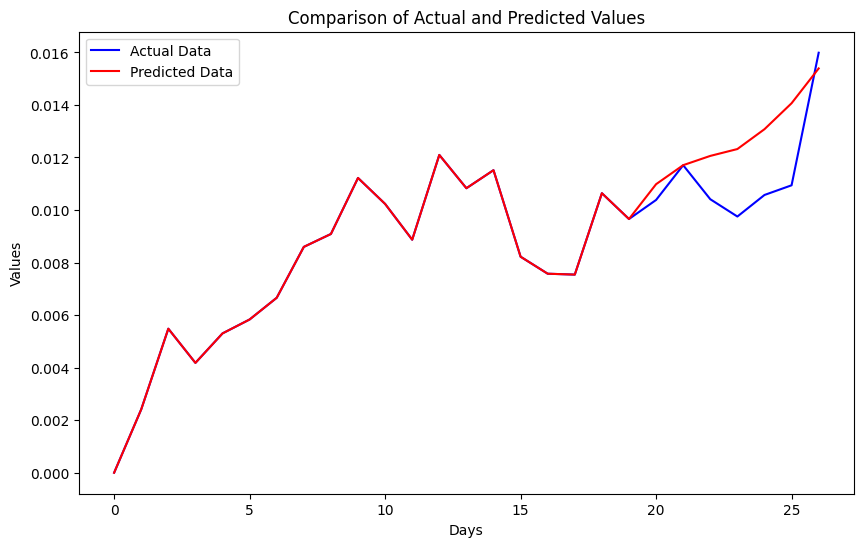

In [264]:
predicted_result = np.concatenate((x_input, y_output))
predicted_result
model_plot(normalized_data[:27],predicted_result)

### *Input*=> 20 days   , *Output* => 7 days

In [267]:
def create_dataset(dataset, time_step=1, output=1):
    X, Y = [], []

    for i in range(len(dataset) - time_step - output):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        
        b = dataset[(i + time_step):(i + time_step + output), 0]  # 7days after 20
        Y.append(b)
    
    return np.array(X), np.array(Y)


In [268]:
time_step=20
output=7
X_train,y_train=create_dataset(train_data,time_step,output)
X_test,y_test=create_dataset(test_data,time_step,output)
print(f"X_train: {X_train.shape} \ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (1189, 20) 
y_train: (1189, 7)
X_test: (277, 20)
y_test: (277, 7)


In [269]:
dense_model_2=Sequential()
dense_model_2.add(Dense(512,input_shape=(20,),activation="relu"))
dense_model_2.add(Dense(256,activation="relu"))
dense_model_2.add(Dense(128,activation="relu"))
dense_model_2.add(Dense(256,activation="relu"))
dense_model_2.add(Dense(128,activation="relu"))
dense_model_2.add(Dense(7))
dense_model_2.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.0001), metrics=['mean_absolute_error'])
dense_model_2.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_47 (Dense)                │ (None, 512)            │        10,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,799 (944.53 KB)

 Trainable params: 241,799 (944.53 KB)

 Non-trainable params: 0 (0.00 B)

In [270]:
history_2=dense_model_2.fit(
    X_train,y_train,
    epochs=100,
    validation_data=(X_test,y_test),
    verbose=1
)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1548 - mean_absolute_error: 0.1548 - val_loss: 0.1028 - val_mean_absolute_error: 0.1028
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0243 - mean_absolute_error: 0.0243 - val_loss: 0.0384 - val_mean_absolute_error: 0.0384
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126 - mean_absolute_error: 0.0126 - val_loss: 0.0360 - val_mean_absolute_error: 0.0360
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0114 - mean_absolute_error: 0.0114 - val_loss: 0.0354 - val_mean_absolute_error: 0.0354
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 - mean_absolute_error: 0.0113 - val_loss: 0.0379 - val_mean_absolute_error: 0.0379
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104 - mean_absolute_error: 0.0104 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - mean_absolute_error: 0.0100 - val_loss

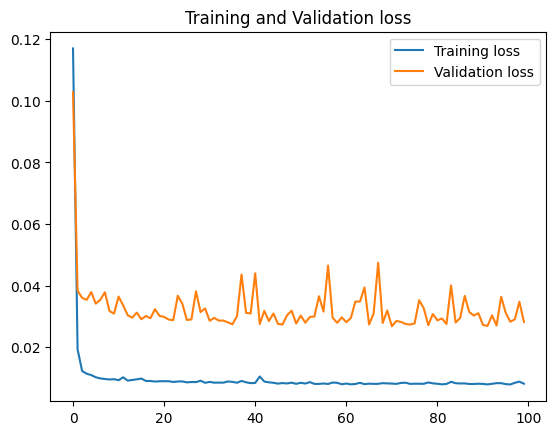

In [271]:
history_plot(history_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


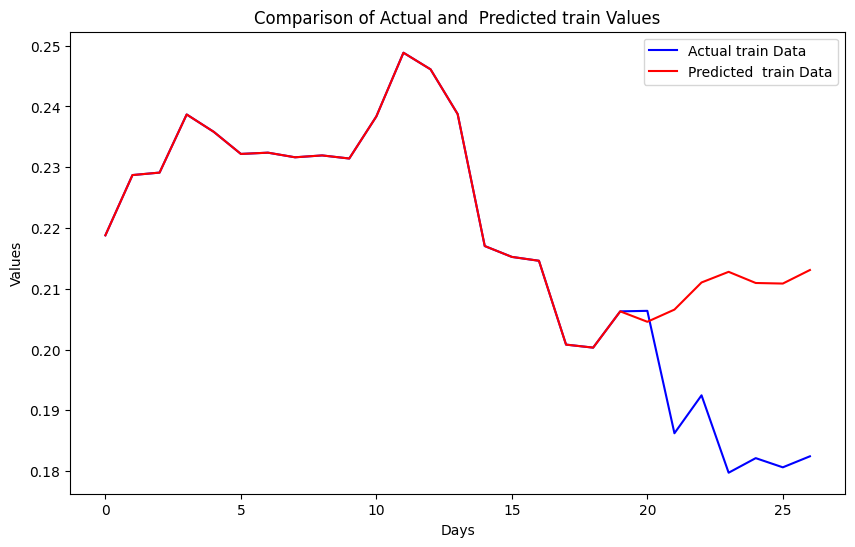

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


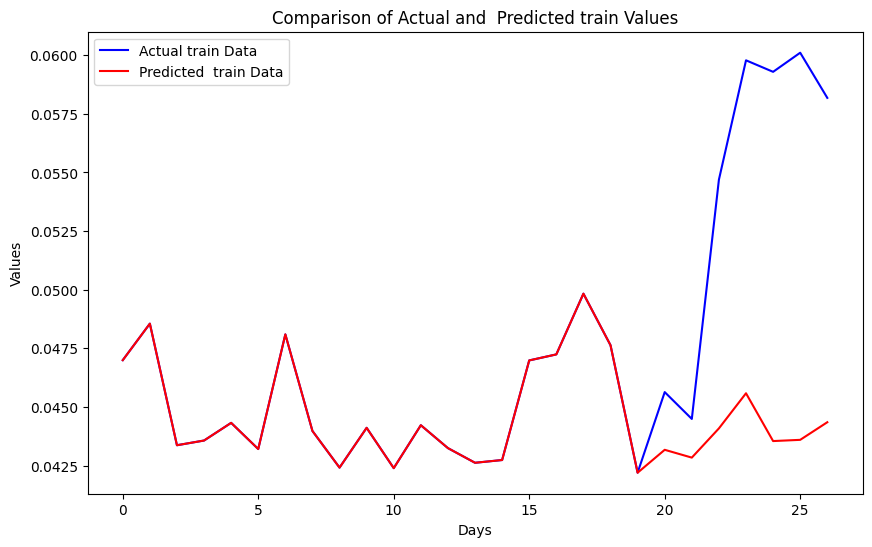

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


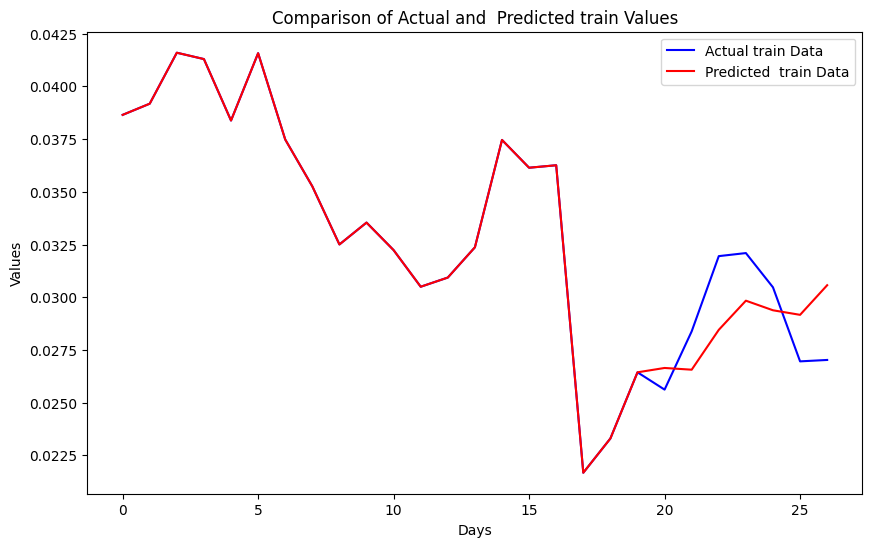

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


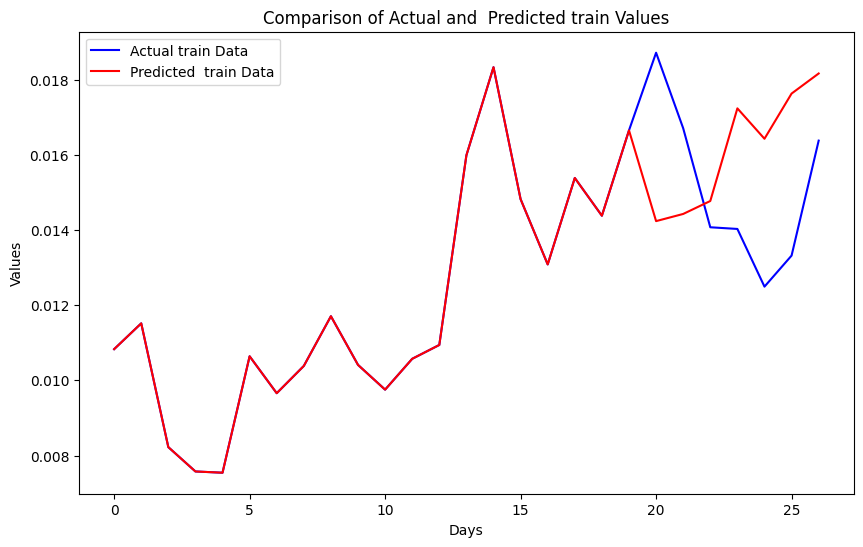

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


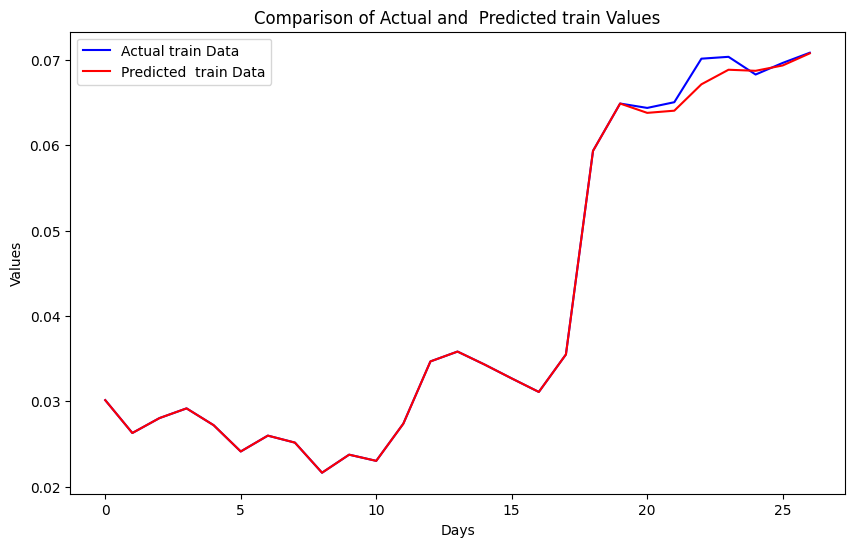

In [272]:
def calculate_random_sequences(n_random, model, x_train):
    for i in range(n_random):
        r = random.randint(0, len(x_train))
        x_temp = X_train[r]
        original_data = list(x_temp)
        for idx in range(1, 8):
            y_next = X_train[r+idx]
            original_data.append(y_next[-1])
        y_temp = model.predict(x_temp.reshape(1, -1))
        x_input = np.array(x_temp)
        y_output = np.array(y_temp).reshape(-1)
        predicted_result = np.concatenate((x_input, y_output))


        plt.figure(figsize=(10, 6))
        plt.plot(original_data, label='Actual train Data', color='blue')
        plt.plot(predicted_result, label='Predicted  train Data', color='red')
        plt.title('Comparison of Actual and  Predicted train Values')
        plt.xlabel('Days')
        plt.ylabel('Values')
        plt.legend()
        plt.show()
calculate_random_sequences(5,dense_model_2, X_train)

## *LSTM* (Long Short Term Memory)




###  **Input** => 20 days , **Output** =>1 day
Our model is going to forecast for 1 day using the last 20 days

In [273]:
time_step=20
output=1
X_train,y_train=create_dataset(train_data,time_step,output)
X_test,y_test=create_dataset(test_data,time_step,output)
print(f"X_train: {X_train.shape} \ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (1195, 20) 
y_train: (1195, 1)
X_test: (283, 20)
y_test: (283, 1)


### Reshape the data

In [274]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print(f"X_test shape => {X_test.shape}\nX_train shape => {X_train.shape}")

X_test shape => (283, 20, 1)
X_train shape => (1195, 20, 1)


### creat the model

In [275]:
lstm_model_1=Sequential()
lstm_model_1.add(LSTM(50,return_sequences=True,input_shape=(20,1)))
lstm_model_1.add(LSTM(50,return_sequences=True))
lstm_model_1.add(LSTM(50))
lstm_model_1.add(Dense(1))
lstm_model_1.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.0001), metrics=['mean_absolute_error'])
lstm_model_1.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [276]:
history_3=lstm_model_1.fit(
    X_train,y_train,
    epochs=100,
    validation_data=(X_test,y_test),
    verbose=1
)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.1762 - mean_absolute_error: 0.1762 - val_loss: 0.3578 - val_mean_absolute_error: 0.3578
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0626 - mean_absolute_error: 0.0626 - val_loss: 0.0460 - val_mean_absolute_error: 0.0460
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0155 - mean_absolute_error: 0.0155 - val_loss: 0.0607 - val_mean_absolute_error: 0.0607
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0138 - mean_absolute_error: 0.0138 - val_loss: 0.0697 - val_mean_absolute_error: 0.0697
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0124 - mean_absolute_error: 0.0124 - val_loss: 0.0459 - val_mean_absolute_error: 0.0459
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0131 - mean_absolute_error: 0.0131 - val_loss: 0.0483 - val_mean_absolute_error: 0.0483
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0126 - mean_absolute_error: 0.0126 - v

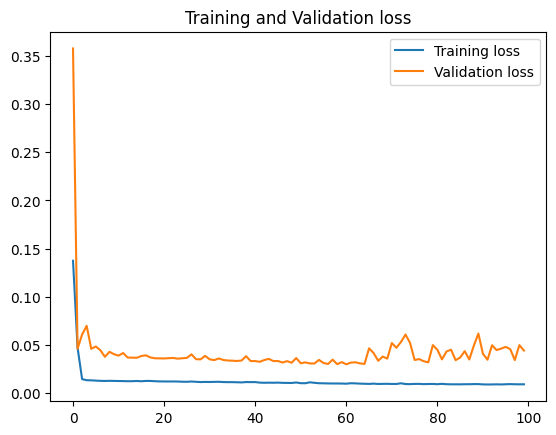

In [277]:
history_plot(history_3)

## Model predict

In [278]:
train_predict = lstm_model_1.predict(X_train)
test_predict = lstm_model_1.predict(X_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


### calculate the errors

In [279]:
# calculate MSE

mse_error=mse(y_train,train_predict)
print(f"Mean Squared error : {mse_error} " )

# calculate MAE
mae_error= mae(y_train,train_predict)
print(f"Mean absolute error for train data : {mae_error} ")
mae_error= mae(y_test,test_predict)
print(f"Mean absolute error for test data : {mae_error} ")

Mean Squared error : 0.00015751762190681102 
Mean absolute error for train data : 0.009029541205325843 
Mean absolute error for test data : 0.044071174719926234 


### Comparison of Actual and Predicted  Train and test Values

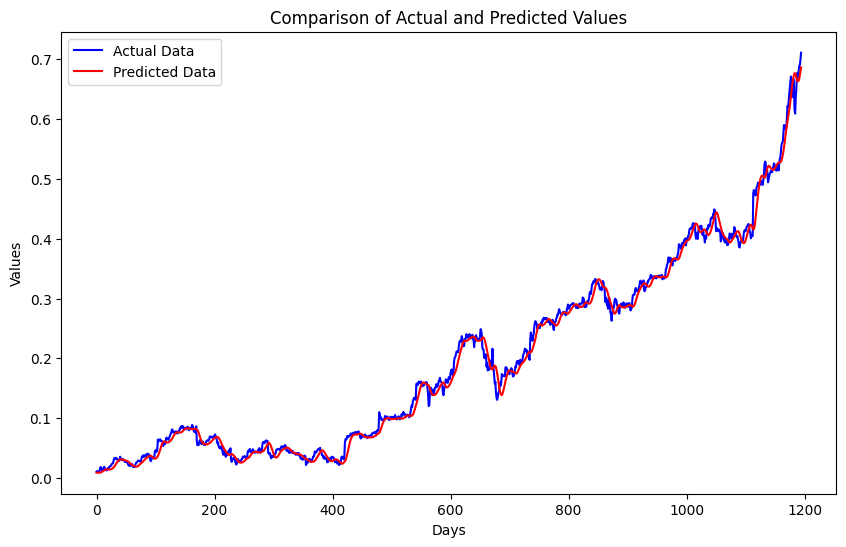

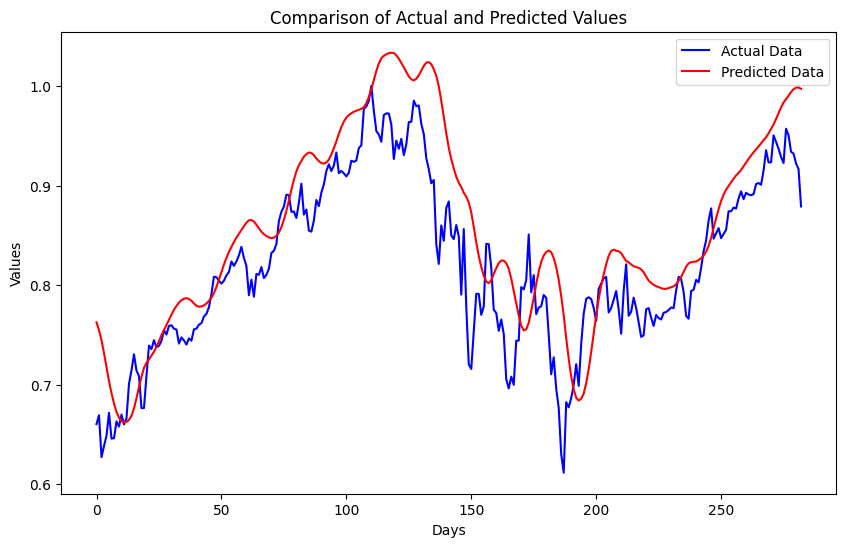

In [280]:
model_plot(y_train,train_predict)
model_plot(y_test,test_predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


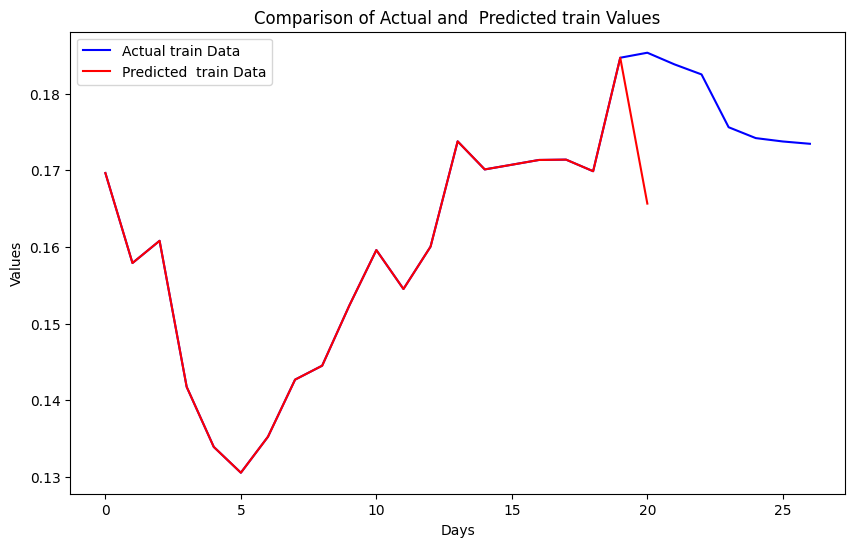

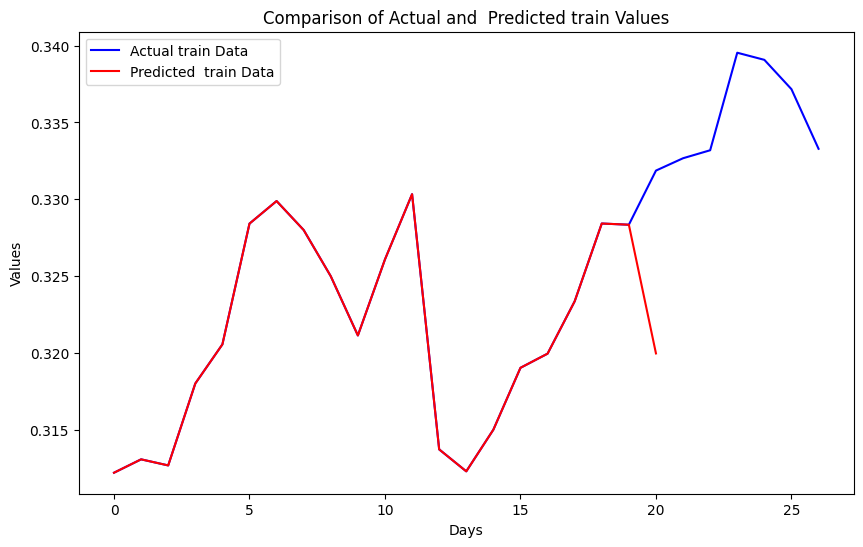

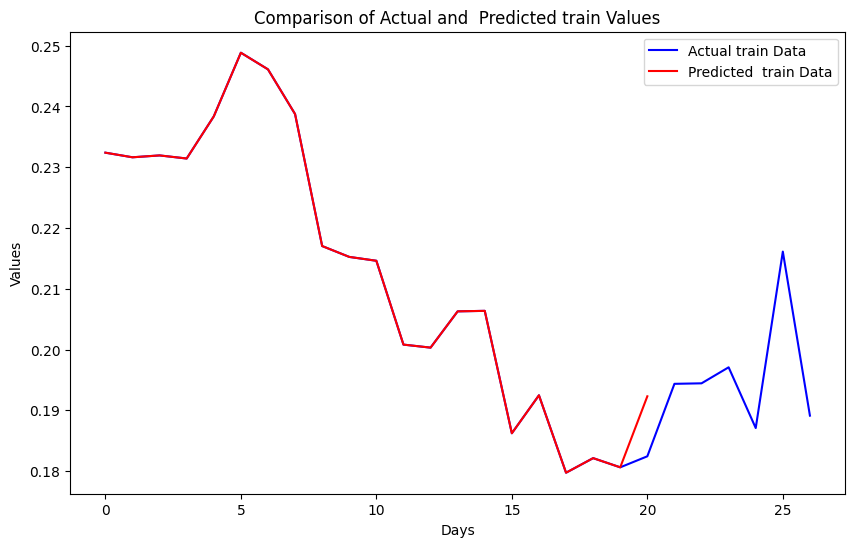

In [282]:
def calculate_random_sequences_lstm(n_random,model,X_train):
    for i in range(n_random):
        r = random.randint(0, len(X_train) - 8) 
        x_temp = X_train[r]
        original_data = list(x_temp.flatten())  

        # Append values from the next sequences
        for idx in range(1, 8):
            y_next = X_train[r + idx]
            original_data.append(y_next[-1, -1])  # Append the last value of the sequence
        original_data = np.array(original_data).reshape(-1, 1)  

        y_temp =model.predict(x_temp.reshape(1, x_temp.shape[0], 1))  # Reshape to 3D (batch_size, timesteps, features)
        x_input = np.array(x_temp)
        y_output = np.array(y_temp).reshape(-1)  # Flatten the predicted output
        predicted_result = np.concatenate((x_input.flatten(), y_output))  # Flatten and concatenate
        
        #plot 
        plt.figure(figsize=(10, 6))
        plt.plot(original_data, label='Actual train Data', color='blue')
        plt.plot(predicted_result, label='Predicted  train Data', color='red')
        plt.title('Comparison of Actual and  Predicted train Values')
        plt.xlabel('Days')
        plt.ylabel('Values')
        plt.legend()
calculate_random_sequences_lstm(3,lstm_model_1,X_train)       

### **Input** => 20 days , **Output** => 7 days
Our model is going to forecast for 7 days using the last 20 days

In [283]:
time_step=20
output=7
X_train,y_train=create_dataset(train_data,time_step,output)
X_test,y_test=create_dataset(test_data,time_step,output)
print(f"X_train: {X_train.shape} \ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (1189, 20) 
y_train: (1189, 7)
X_test: (277, 20)
y_test: (277, 7)


#### Reshaping

In [284]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print(f"X_test shape => {X_test.shape}\nX_train shape => {X_train.shape}")

X_test shape => (277, 20, 1)
X_train shape => (1189, 20, 1)


In [285]:
lstm_model_2=Sequential()
lstm_model_2.add(LSTM(50,return_sequences=True,input_shape=(20,1)))
lstm_model_2.add(LSTM(50,return_sequences=True))
lstm_model_2.add(LSTM(50))
lstm_model_2.add(Dense(7))
lstm_model_2.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.0001), metrics=['mean_absolute_error'])
lstm_model_2.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 7)              │           357 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,157 (199.83 KB)

 Trainable params: 51,157 (199.83 KB)

 Non-trainable params: 0 (0.00 B)

In [286]:
history_4=lstm_model_2.fit(
    X_train,y_train,
    epochs=100,
    validation_data=(X_test,y_test),
    verbose=1
)

Epoch 1/100


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.1839 - mean_absolute_error: 0.1839 - val_loss: 0.6512 - val_mean_absolute_error: 0.6512
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1152 - mean_absolute_error: 0.1152 - val_loss: 0.1636 - val_mean_absolute_error: 0.1636
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0380 - mean_absolute_error: 0.0380 - val_loss: 0.0779 - val_mean_absolute_error: 0.0779
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0185 - mean_absolute_error: 0.0185 - val_loss: 0.0555 - val_mean_absolute_error: 0.0555
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0168 - mean_absolute_error: 0.0168 - val_loss: 0.0556 - val_mean_absolute_error: 0.0556
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0160 - mean_absolute_error: 0.0160 - val_loss: 0.0591 - val_mean_absolute_error: 0.0591
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0158 - mean_absolute_error: 0.0158 - val_loss: 0.0

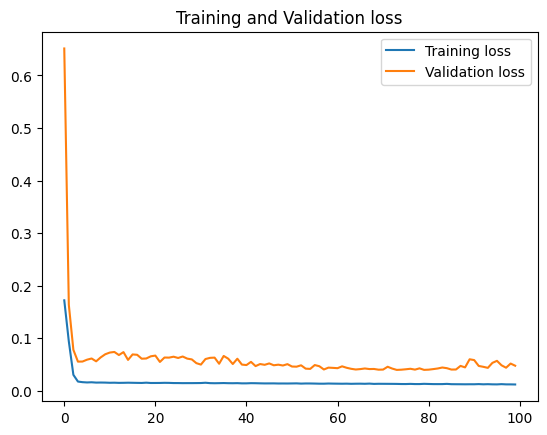

In [287]:
plt.plot(history_4.history['loss'],label='Training loss')
plt.plot(history_4.history['val_loss'],label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

### Model predicted

In [289]:
train_predict = lstm_model_2.predict(X_train)
test_predict = lstm_model_2.predict(X_test)
print(y_train.shape)
print(train_predict.shape)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(1189, 7)
(1189, 7)


### Calculate errors

In [290]:
# calculate MSE
mse_error=mse(y_train,train_predict)
print(f"Mean Squared error : {mse_error} " )

# calculate MAE
mae_error= mae(y_train,train_predict)
print(f"Mean absolute error for train : {mae_error} ")
mae_error= mae(y_test,test_predict)
print(f"Mean absolute error for test  : {mae_error} ")

Mean Squared error : 0.00028420048792367485 
Mean absolute error for train : 0.012037574119517632 
Mean absolute error for test  : 0.04765177213495433 


### Forcasting for lstm model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


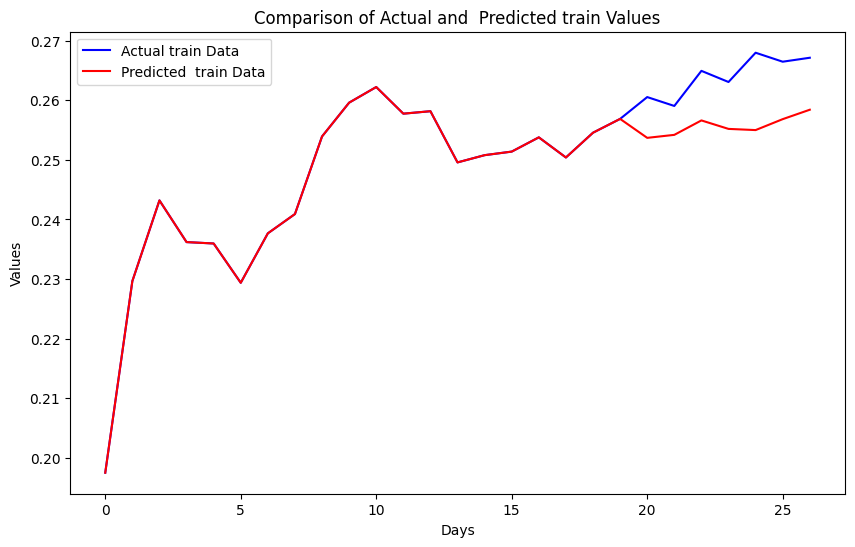

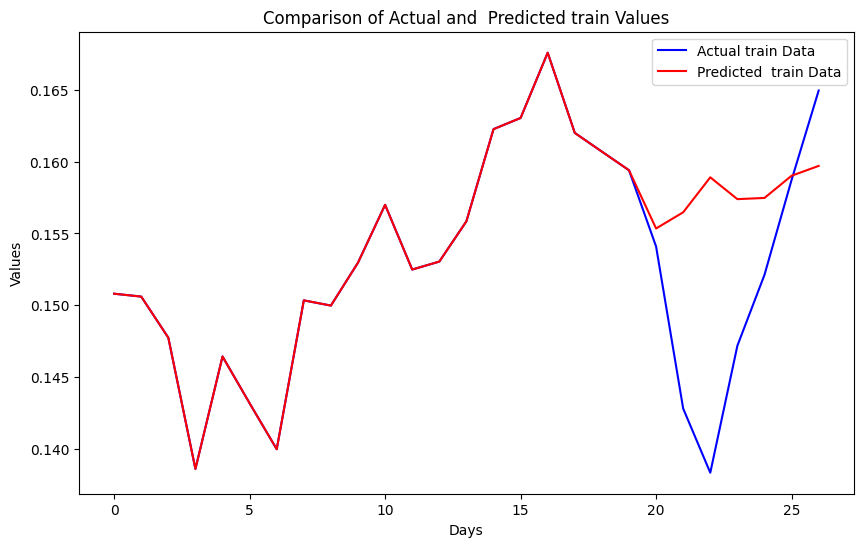

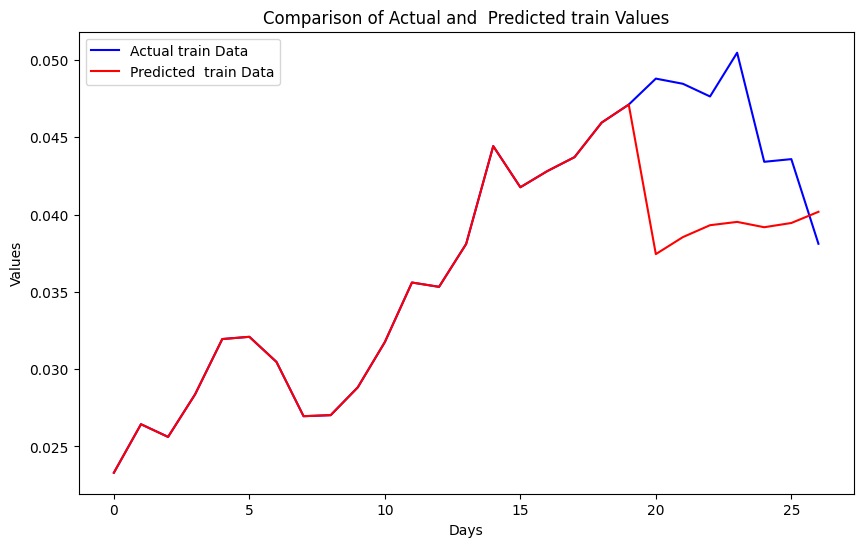

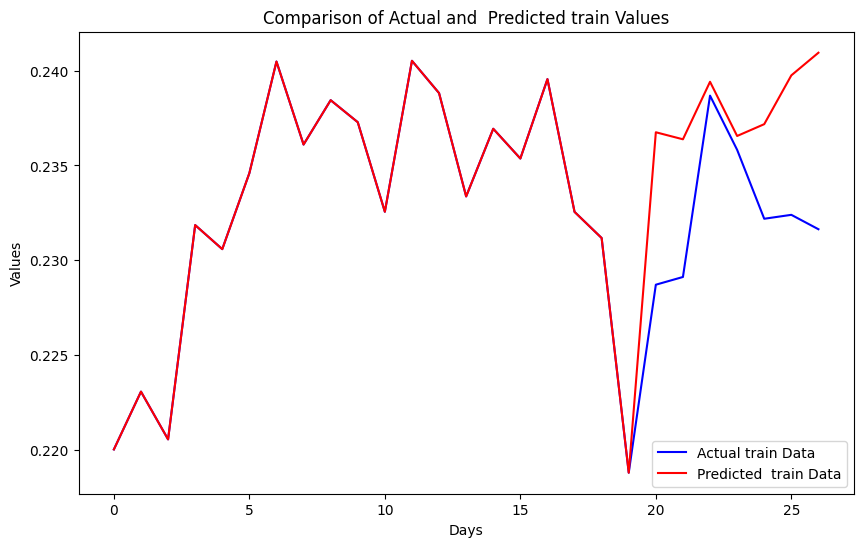

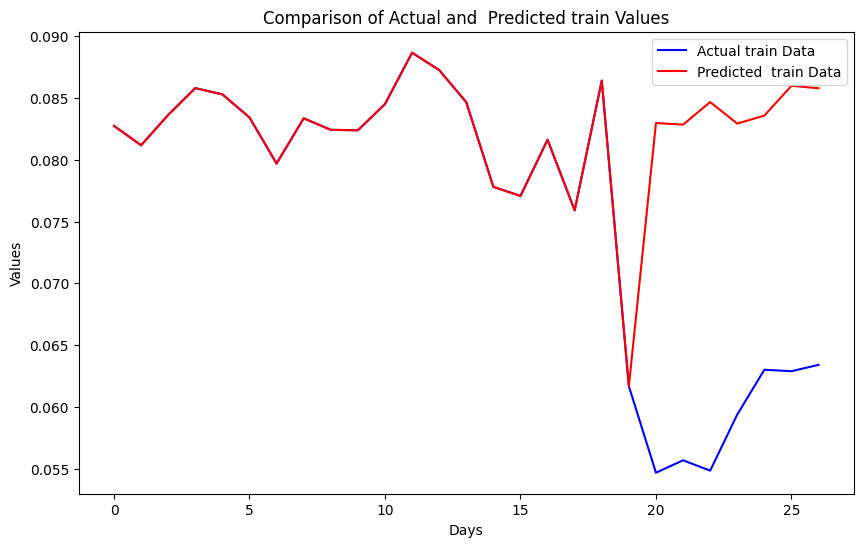

In [291]:
calculate_random_sequences_lstm(5,lstm_model_2,X_train)